In [1]:
import os, sys, json, umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10, "font.family":"Arial"})
from sklearn.preprocessing import StandardScaler
from utils import *
from rnn_models import *
from numpy.linalg import norm
from collections import Counter

2023-07-19 18:13:30.510544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
epitope_naming = {'C3_V3': 'C3/V3', 'CD4bs': 'CD4bs', 'V1_V2': 'V1/V2', 'gp120_gp41': 'gp120-gp41', 'MPER': 'MPER'}

In [3]:
def epitope_accuracy(k, similarities):    
    acc = 0
    acc_2 = 0
    for bnAb in bnAbs_of_interest:
        sim_bnAbs = similarities[bnAb].sort_values()[-k-1:-1]
        epis = []
        for i,j in sim_bnAbs.items():
            epis.append(bnAbs_to_epitope[i])
        pred_epi = Counter(epis).most_common(1)[0][0]
        if pred_epi == bnAbs_to_epitope[bnAb]: 
            acc += 1
        if bnAbs_to_epitope[bnAb] in epis:
            acc_2 += 1
    return acc/33, acc_2/33

In [4]:
with open('config.json') as params_json:
    params = json.load(params_json)
pretrain_params = params['pretrain_params']
fine_tune_params = params['fine_tune_params']

model_name = 'LBUM'
params = {  'pretrain_embedding_size':  pretrain_params['embedding_size'], 
            'pretrain_n_units': pretrain_params['n_units'], 
            'pretrain_n_layers': pretrain_params['n_layers'], 
            'pretrained_model_filepath': '../pretrained_models/pretrained_model_epoch27.hdf5', 
            'learning_rate': fine_tune_params['learning_rate'], 
            'attention_neurons': fine_tune_params['attention_neurons'],
            'n_layers_to_train':fine_tune_params['n_layers_to_train'],
            'dropout_rate': fine_tune_params['dropout_rate']}
data = []
for fold in range(1,6,1):
    print('fold', fold)
    model = build_LBUM(params)
    model.load_weights(f'../final_trained_models/fold{fold}_{model_name}.hdf5')
    emb_layer = model.get_layer('bnAbs_contexts')
    bnAbs_embs = emb_layer.get_weights()[0]
    bnAbs_to_embs = {}
    for bnAb in all_antibodies:
        bnAbs_to_embs[bnAb] = bnAbs_embs[all_antibodies.index(bnAb)]
    bnAbs_embs = pd.DataFrame.from_dict(bnAbs_to_embs).T
    sorted_bnAbs = []
    for epitope in grouped_bnAbs_of_interest:
        for bnAb in grouped_bnAbs_of_interest[epitope]:
            sorted_bnAbs.append(bnAb)
        
    similarities = {}
    for bnAb in sorted_bnAbs:
        similarities[bnAb] = []
        d = bnAbs_embs.loc[bnAb]
        for bnAb2 in sorted_bnAbs:
            d2 = bnAbs_embs.loc[bnAb2]
            sim = np.dot(d, d2)/(norm(d)*norm(d2))
            similarities[bnAb].append(sim)
    similarities = pd.DataFrame.from_dict(similarities, orient='index', columns = sorted_bnAbs)
    for k in range(1,6,1):
        acc, acc_2 = epitope_accuracy(k, similarities)
        data.append((fold, k, acc, acc_2))
data = pd.DataFrame(data, columns=['fold', 'number of neighbors', 'majority accuracy', 'detection accuracy'])

fold 1
loading pretrained model
fold 2
loading pretrained model
fold 3
loading pretrained model
fold 4
loading pretrained model
fold 5
loading pretrained model


In [5]:
means = pd.DataFrame(data.groupby(['number of neighbors'])[['majority accuracy', 'detection accuracy']].mean())
stds = pd.DataFrame(data.groupby(['number of neighbors'])[['majority accuracy', 'detection accuracy']].std())
means['majority accuracy'] = [f'{x:.2f} ({y:.2f})' for x,y in zip(means['majority accuracy'], stds['majority accuracy'])]
means['detection accuracy'] = [f'{x:.2f} ({y:.2f})' for x,y in zip(means['detection accuracy'], stds['detection accuracy'])]
# means.to_csv(f'../../temp/predicting_epitopes.csv')
means

,majority accuracy,detection accuracy
number of neighbors,,
1,0.76 (0.02),0.76 (0.02)
2,0.70 (0.11),0.84 (0.06)
3,0.71 (0.07),0.87 (0.06)
4,0.72 (0.05),0.90 (0.03)
5,0.68 (0.05),0.92 (0.03)


# bnAb contexts

loading pretrained model


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


loading pretrained model
loading pretrained model
loading pretrained model
loading pretrained model


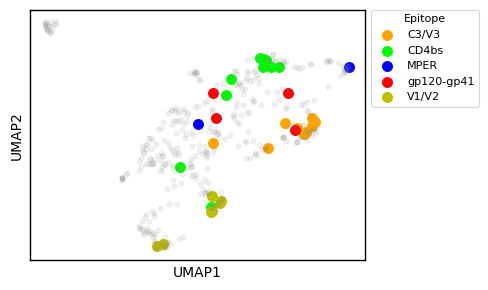

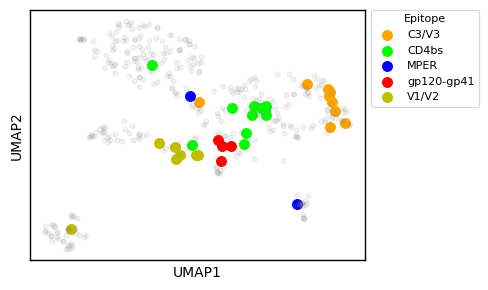

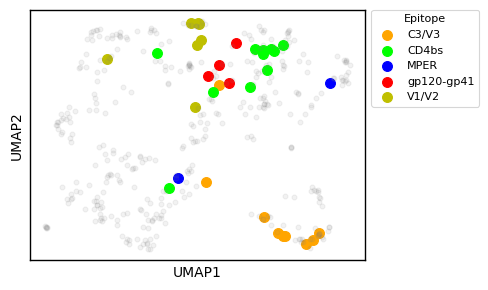

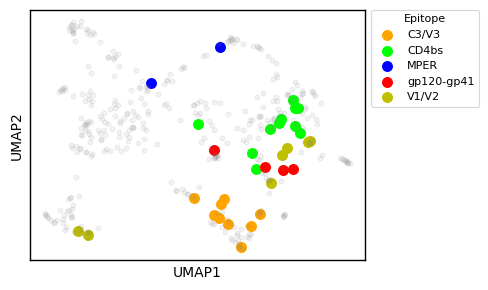

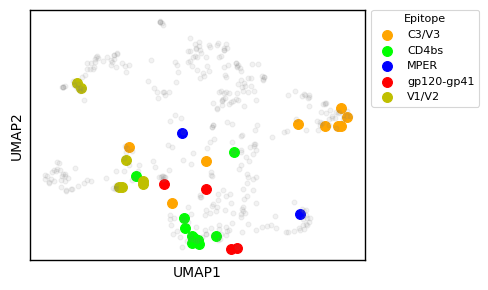

In [6]:
for fold in range(1,6,1):
    model = build_LBUM(params)
    model.load_weights(f'../final_trained_models/fold{fold}_LBUM.hdf5')
    emb_layer = model.get_layer('bnAbs_contexts')
    bnAbs_embs = emb_layer.get_weights()[0]
    bnAbs_to_embs = {}
    for bnAb in all_antibodies:
        bnAbs_to_embs[bnAb] = bnAbs_embs[all_antibodies.index(bnAb)]
    bnAbs_embs = pd.DataFrame.from_dict(bnAbs_to_embs).T
    bnAbs_embs

    colors = {'MPER':'blue', 'C3_V3': 'orange', 'CD4bs': 'lime', 'gp120_gp41': 'red', 'V1_V2': 'y'}
    fig, ax = plt.subplots(figsize=(5,3))
    X = bnAbs_embs.to_numpy()
    scaled_X = StandardScaler().fit_transform(X)
    umapper = umap.UMAP(transform_seed=0, random_state=0)
    reduced_X_umap = umapper.fit_transform(scaled_X)
    for epitope in grouped_bnAbs_of_interest:
        xs = [x for x,y in zip(reduced_X_umap[:, 0], bnAbs_embs.iterrows()) if y[0] in grouped_bnAbs_of_interest[epitope]]
        ys = [x for x,y in zip(reduced_X_umap[:, 1], bnAbs_embs.iterrows()) if y[0] in grouped_bnAbs_of_interest[epitope]]
        bs = [y[0] for y in bnAbs_embs.iterrows() if y[0] in grouped_bnAbs_of_interest[epitope]]
        ax.scatter(
            xs,
            ys,
            color=colors[epitope],
            label = epitope,
            marker='.',
            alpha=1,
            s=200
        )

#         for i, bnAb in enumerate(bs):
#             if bnAb == 'VRC26.25':
#                 ax.annotate(bnAb, (xs[i], ys[i]), xytext=(xs[i]-0.4, ys[i]+0.05), fontsize=8)
#             elif bnAb == 'VRC26.08':
#                 ax.annotate(bnAb, (xs[i], ys[i]), xytext=(xs[i]-0.4, ys[i]-0.15), fontsize=8)
        
    xs = [x for x,y in zip(reduced_X_umap[:, 0], bnAbs_embs.iterrows()) if y[0] not in bnAbs_of_interest]
    ys = [x for x,y in zip(reduced_X_umap[:, 1], bnAbs_embs.iterrows()) if y[0] not in bnAbs_of_interest]
    ax.scatter(
        xs,
        ys,
        color='grey',
        marker='.',
        alpha=0.1,
        s=50
    )
        
    ax.legend(['C3/V3', 'CD4bs', 'MPER', 'gp120-gp41', 'V1/V2'], fontsize=8, title='Epitope', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

    plt.xticks([]),plt.yticks([])
    plt.setp(ax.get_legend().get_title(), fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../temp/bnAb_fold{fold}_contexts.tiff', format='tiff', dpi=600)